# Investment Analysis Assignment
### You work for Spark Funds, an asset management company. Spark Funds wants to make investments in a few companies. The CEO of Spark Funds wants to understand the global trends in investments so that she can take the investment decisions effectively.

Let's start with detection of character set used in encoding of this data

In [1]:
import chardet
# Reading first 1Million bytes as sample
rawdata = open('rounds2.csv', 'rb').read(1000000)
result = chardet.detect(rawdata)
print('Detected encoding ' + result['encoding'] + ' at confidence of ' + str(result['confidence']))

Detected encoding Windows-1252 at confidence of 0.73


Let's try reading the file with the detected encoding

In [2]:
# Importing essentials
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# Set graph style
plt.style.use('ggplot')

In [3]:
# Reading the data from files
try:
    companies = pd.read_csv('./companies.csv', encoding='windows-1252')
    rounds2 = pd.read_csv('./rounds2.csv', encoding='windows-1252')
except:
    print('An Error was thrown while reading the file data in Pandas')

An Error was thrown while reading the file data in Pandas


Apparently **Pandas cannot detect windows-1252 encoding** used in this file. So we will try to use another one

In [4]:
# Reading with unicode_escape
companies = pd.read_csv('./companies.csv', encoding='unicode_escape')
rounds2 = pd.read_csv('./rounds2.csv', encoding='unicode_escape')

In [5]:
# Display companies data
companies.head()

permalink                    name  \
0                  /Organization/-Fame                   #fame   
1               /Organization/-Qounter                :Qounter   
2  /Organization/-The-One-Of-Them-Inc-  (THE) ONE of THEM,Inc.   
3                /Organization/0-6-Com                 0-6.com   
4       /Organization/004-Technologies        004 Technologies   

                        homepage_url  \
0                 http://livfame.com   
1             http://www.qounter.com   
2                http://oneofthem.jp   
3                 http://www.0-6.com   
4  http://004gmbh.de/en/004-interact   

                                       category_list     status country_code  \
0                                              Media  operating          IND   
1  Application Platforms|Real Time|Social Network...  operating          USA   
2                                  Apps|Games|Mobile  operating          NaN   
3                                        Curated Web  operating          CHN   
4                                           Software  operating          USA   

  state_code                 region           city  founded_at  
0         16                 Mumbai         Mumbai         NaN  
1         DE             DE - Other  Delaware City  04-09-2014  
2        NaN                    NaN            NaN         NaN  
3         22                Beijing        Beijing  01-01-2007  
4         IL  Springfield, Illinois      Champaign  01-01-2010

In [6]:
# Display funding data
rounds2.head()

company_permalink  \
0                  /organization/-fame   
1               /ORGANIZATION/-QOUNTER   
2               /organization/-qounter   
3  /ORGANIZATION/-THE-ONE-OF-THEM-INC-   
4                /organization/0-6-com   

                           funding_round_permalink funding_round_type  \
0  /funding-round/9a01d05418af9f794eebff7ace91f638            venture   
1  /funding-round/22dacff496eb7acb2b901dec1dfe5633            venture   
2  /funding-round/b44fbb94153f6cdef13083530bb48030               seed   
3  /funding-round/650b8f704416801069bb178a1418776b            venture   
4  /funding-round/5727accaeaa57461bd22a9bdd945382d            venture   

  funding_round_code   funded_at  raised_amount_usd  
0                  B  05-01-2015         10000000.0  
1                  A  14-10-2014                NaN  
2                NaN  01-03-2014           700000.0  
3                  B  30-01-2014          3406878.0  
4                  A  19-03-2008          2000000.0

**Permalink in companies dataframe, and rounds2 dataframe can be used as a key to relate the two dataframes. However, looking at the values, it seems that *permalinks are not standardised with respect to casing*. Hence, better to coonvert both the rounds2 dataframe adn companies dataframe permalinks to lowercase**

In [7]:
# Converting permalinks to lowercase
rounds2['company_permalink'] = rounds2['company_permalink'].str.lower()
companies.permalink = companies.permalink.str.lower()

In [8]:
# Finding unique companies in rounds dataframe using permalink
rounds2['company_permalink'].nunique()

66370

In [9]:
# Finding unique companies in companies dataframe using permalink
companies.permalink.nunique()

66368

**Clearly there are 2 unique permalink that are in rounds2 but not in companies. Let's check those permalinks.**

In [10]:
#Find the values of permalink in rounds2 but not in companies
result = rounds2[~rounds2['company_permalink'].isin(companies.permalink)]
#finding unique values from the result
result['company_permalink'].unique()

array(['/organization/e-cã\x8abica',
       '/organization/energystone-games-ç\x81µç\x9f³æ¸¸æ\x88\x8f',
       '/organization/huizuche-com-æ\x83\xa0ç§ÿè½¦',
       '/organization/magnet-tech-ç£\x81ç\x9f³ç§\x91æ\x8a\x80',
       '/organization/tipcat-interactive-æ²\x99è\x88ÿä¿¡æ\x81¯ç§\x91æ\x9a\x80',
       '/organization/weiche-tech-å\x96\x82è½¦ç§\x91æ\x8a\x80',
       '/organization/zengame-ç¦\x85æ¸¸ç§\x91æ\x8a\x80'], dtype=object)

*It seems like there are actually 7 values in rounds2 but not in companies. but the difference in their unique values is only 2. That indicates there must be 5 values in companies dataframe as well which might not be in rounds2.*

In [11]:
companies[~companies.permalink.isin(rounds2['company_permalink'])].permalink.unique()

array(['/organization/e-cã\x9abica',
       '/organization/energystone-games-ç\x81µçÿ³æ¸¸æ\x88\x8f',
       '/organization/huizuche-com-æ\x83\xa0ç§\x9fè½¦',
       '/organization/tipcat-interactive-æ²\x99è\x88\x9fä¿¡æ\x81¯ç§\x91æ\x9a\x80',
       '/organization/zengame-ç¦\x85æ¸¸ç§\x91æ\x9a\x80'], dtype=object)

We got the results as expected. However, **on closer analysis, it is found that the values returned as unique to only companies are also present in rounds2 dataframe. Same applies for some values in rounds2 dataframe as well. Only way they are differing is with regards to extra special characters.** This seems to be like parsing/encoding issue with Pandas. So we need to purge non-ascii characters

In [12]:
# Purge non-ascii characters
rounds2['company_permalink'] = rounds2['company_permalink'].str.encode('utf-8').str.decode('ascii', 'ignore')
companies.permalink = companies.permalink.str.encode('utf-8').str.decode('ascii', 'ignore')

In [13]:
# #Find the values of permalink in companies but not in rounds2
company_exclusive_values = companies[~companies.permalink.isin(rounds2['company_permalink'])].permalink.unique()
# #Find the values of permalink in rounds2 but not in companies
rounds2_exclusive_values = rounds2[~rounds2['company_permalink'].isin(companies.permalink)]['company_permalink'].unique()
print(company_exclusive_values, rounds2_exclusive_values)

[] []


*Hence there are no values that are exclusive to any of the dataframe. To cross check:*

In [14]:
# Rechekcing unique values
print( rounds2['company_permalink'].nunique(), companies.permalink.nunique())

66368 66368


*Both have returned same number of unique values.* So we can safely say we have data for all companies which have participated in round2 funding.

### Merging Data

In [15]:
# Merge rounds2 and companies data on basis of permalink
master_frame = pd.merge(companies, rounds2, left_on='permalink', right_on='company_permalink', how='inner')
master_frame.head()
mf_copy = master_frame.copy()

In [16]:
# checking for values different in company_permalink and permalink
master_frame[master_frame.permalink != master_frame['company_permalink']]

Empty DataFrame
Columns: [permalink, name, homepage_url, category_list, status, country_code, state_code, region, city, founded_at, company_permalink, funding_round_permalink, funding_round_type, funding_round_code, funded_at, raised_amount_usd]
Index: []

The permalink and company_permalink columns are same everywhere and are redundant. Hence one of them can be removed.

In [17]:
# Drop redundant permalink column
master_frame.drop('company_permalink', axis=1, inplace=True)

In [18]:
master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114949 entries, 0 to 114948
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   permalink                114949 non-null  object 
 1   name                     114948 non-null  object 
 2   homepage_url             108815 non-null  object 
 3   category_list            111539 non-null  object 
 4   status                   114949 non-null  object 
 5   country_code             106271 non-null  object 
 6   state_code               104003 non-null  object 
 7   region                   104782 non-null  object 
 8   city                     104785 non-null  object 
 9   founded_at               94428 non-null   object 
 10  funding_round_permalink  114949 non-null  object 
 11  funding_round_type       114949 non-null  object 
 12  funding_round_code       31140 non-null   object 
 13  funded_at                114949 non-null  object 
 14  rais

In [19]:
# Save original dataframe for later use
original_data_size = master_frame.shape
original_data_size

(114949, 15)

## Data Cleaning

### 1. Checking for Duplicate data 

In [20]:
# Checking duplicates
master_frame.duplicated().sum()

0

*So there are no duplicate data. Let's proceed to second kind of cleansing.*

### 2. Filtering of unneccessary variables
To Limit our scope of analysis to only the areas that need our attention, *we can remove the columns concerning website details, address details, and funding code.*

In [21]:
master_frame.drop(['homepage_url', 'founded_at', 'region', 'funding_round_code'], axis=1, inplace=True)

### 3. Checking for missing values

In [22]:
# Checking for number of missing values in each column
master_frame.isna().sum()

permalink                      0
name                           1
category_list               3410
status                         0
country_code                8678
state_code                 10946
city                       10164
funding_round_permalink        0
funding_round_type             0
funded_at                      0
raised_amount_usd          19990
dtype: int64

In [23]:
master_frame.head()

permalink                    name  \
0                  /organization/-fame                   #fame   
1               /organization/-qounter                :Qounter   
2               /organization/-qounter                :Qounter   
3  /organization/-the-one-of-them-inc-  (THE) ONE of THEM,Inc.   
4                /organization/0-6-com                 0-6.com   

                                       category_list     status country_code  \
0                                              Media  operating          IND   
1  Application Platforms|Real Time|Social Network...  operating          USA   
2  Application Platforms|Real Time|Social Network...  operating          USA   
3                                  Apps|Games|Mobile  operating          NaN   
4                                        Curated Web  operating          CHN   

  state_code           city                          funding_round_permalink  \
0         16         Mumbai  /funding-round/9a01d05418af9f794eebff7ace91f638   
1         DE  Delaware City  /funding-round/22dacff496eb7acb2b901dec1dfe5633   
2         DE  Delaware City  /funding-round/b44fbb94153f6cdef13083530bb48030   
3        NaN            NaN  /funding-round/650b8f704416801069bb178a1418776b   
4         22        Beijing  /funding-round/5727accaeaa57461bd22a9bdd945382d   

  funding_round_type   funded_at  raised_amount_usd  
0            venture  05-01-2015         10000000.0  
1            venture  14-10-2014                NaN  
2               seed  01-03-2014           700000.0  
3            venture  30-01-2014          3406878.0  
4            venture  19-03-2008          2000000.0

In [24]:
# Checking percentage of missing values in each column
master_frame.isna().sum() / master_frame.shape[0] *100

permalink                   0.000000
name                        0.000870
category_list               2.966533
status                      0.000000
country_code                7.549435
state_code                  9.522484
city                        8.842182
funding_round_permalink     0.000000
funding_round_type          0.000000
funded_at                   0.000000
raised_amount_usd          17.390321
dtype: float64

***There are several variables that are missing values. Let us investigate raised_amount_usd variable and its statistics to see if values can be *imputed in place of missing values* first, since it is the most important variable.***

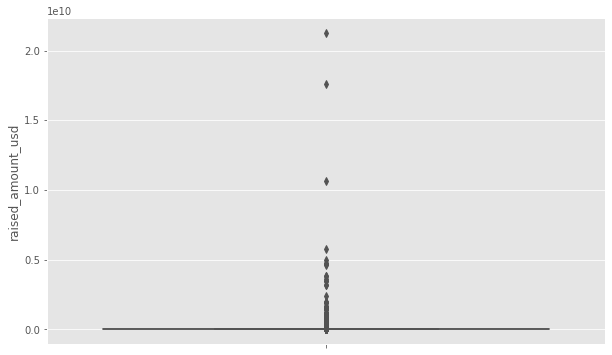

In [25]:
# Checking the value distribution 
plt.figure(figsize=(10, 6))
sns.boxplot(data=master_frame, y='raised_amount_usd');

We can see that the values are mostly *crunched up* in a small space. And there are a *lot of outliers*. 

In [26]:
# Set option to display numbers NOT in format of exponential notation for readability
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# Checking stats
stats = master_frame.raised_amount_usd.describe()
stats

count         94959.000
mean       10426869.335
std       114821247.985
min               0.000
25%          322500.000
50%         1680511.000
75%         7000000.000
max     21271935000.000
Name: raised_amount_usd, dtype: float64

For being thorough, lets analyse the extent of affect outliers have on the distribution, we shall try analysing it without outliers as well.

count      84416.000
mean     3064248.545
std      3984620.674
min            0.000
25%       250000.000
50%      1202613.500
75%      4500000.000
max     17000000.000
Name: raised_amount_usd, dtype: float64

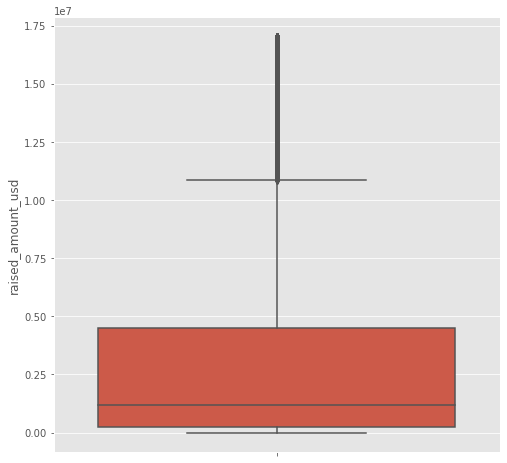

In [27]:
Q1 = stats['25%']
Q3 = stats['75%']
# Computing InterQuartile Range
IQR = Q3-Q1
# Compute edges of acceptable data
lower_lim = Q1-1.5*IQR
upper_lim = Q3+1.5*IQR

plt.figure(figsize=(8,8))
# Create a temporary dataframe to hold rows without outliers
df1 = master_frame[(lower_lim < master_frame.raised_amount_usd) & (master_frame.raised_amount_usd < upper_lim)]
sns.boxplot(data=df1, y='raised_amount_usd');
df1.raised_amount_usd.describe()

Clearly post removal of ouliers the box has a much better visibility. Also, mean and median are much closer compared to the old values.<br/>
***Mean and median are too far apart in data. Also, it is not reasonable to impute any value for the funding amount raised by any company, since one company for which you are imputing a median amount can be too good and would have actually raised a lot of funding. Even if you group by each sector and impute the median of the sector in which the company falls, it would gain a sligh better value for imputation but not a representative one. Hence imputing the values is not an option. We need to drop rows with missing data.***

In [28]:
master_frame.dropna(inplace=True, subset=['raised_amount_usd'])
master_frame.shape

(94959, 11)

In [29]:
# Checking percentage of missing values in each column
master_frame.isna().sum() / master_frame.shape[0] *100

permalink                 0.000
name                      0.001
category_list             1.099
status                    0.000
country_code              6.162
state_code                8.008
city                      7.419
funding_round_permalink   0.000
funding_round_type        0.000
funded_at                 0.000
raised_amount_usd         0.000
dtype: float64

We can see the city, country_code, state_code, category_list are remining with missing data. <br/> Starting with country_code, let's see ***if we can impute the country from city or state, because this data can be gathered from external sources as well.***

In [30]:
# Checking for rows where country is absent but either state/city is available
master_frame[(master_frame.country_code.isna()) & (~master_frame.city.isna() | ~master_frame.state_code.isna())]

Empty DataFrame
Columns: [permalink, name, category_list, status, country_code, state_code, city, funding_round_permalink, funding_round_type, funded_at, raised_amount_usd]
Index: []

**Unfortunately, since there are no rows with country absent & city or statecode present to infer country from, the country data cannot be imputed.<br/> We need to drop the data to remove those rows from our analysis. Since we cannot include these rows in our country analysis, better to remove them altogether (since there can be several values of raised_amount_usd where country_code might be missing and they are significantly large values to affect our raised_amount_usd analysis as well)**

In [31]:
master_frame.dropna(inplace=True, subset=['country_code'])
master_frame.head()

permalink                    name  \
0                  /organization/-fame                   #fame   
2               /organization/-qounter                :Qounter   
4                /organization/0-6-com                 0-6.com   
6     /organization/01games-technology      01Games Technology   
7  /organization/0ndine-biomedical-inc  Ondine Biomedical Inc.   

                                       category_list     status country_code  \
0                                              Media  operating          IND   
2  Application Platforms|Real Time|Social Network...  operating          USA   
4                                        Curated Web  operating          CHN   
6                                              Games  operating          HKG   
7                                      Biotechnology  operating          CAN   

  state_code           city                          funding_round_permalink  \
0         16         Mumbai  /funding-round/9a01d05418af9f794eebff7ace91f638   
2         DE  Delaware City  /funding-round/b44fbb94153f6cdef13083530bb48030   
4         22        Beijing  /funding-round/5727accaeaa57461bd22a9bdd945382d   
6        NaN      Hong Kong  /funding-round/7d53696f2b4f607a2f2a8cbb83d01839   
7         BC      Vancouver  /funding-round/2b9d3ac293d5cdccbecff5c8cb0f327d   

  funding_round_type   funded_at  raised_amount_usd  
0            venture  05-01-2015       10000000.000  
2               seed  01-03-2014         700000.000  
4            venture  19-03-2008        2000000.000  
6        undisclosed  01-07-2014          41250.000  
7               seed  11-09-2009          43360.000

In [32]:
# Checkig for variables with missing values
master_frame.isna().sum()

permalink                     0
name                          1
category_list               579
status                        0
country_code                  0
state_code                 1753
city                       1194
funding_round_permalink       0
funding_round_type            0
funded_at                     0
raised_amount_usd             0
dtype: int64

*There is one row with missing name. However, the company can be uniquely identified with permalink so ignore it.*<br/>
**category_list is another variable with missing value. However, unlike others, instead of removing such rows, we can impute the category_list missing values with 'Unknown'**

In [33]:
# Impute 'Unknown' in place of NA
master_frame.category_list.fillna('Unknown', inplace=True)

In [34]:
master_frame.isna().sum()

permalink                     0
name                          1
category_list                 0
status                        0
country_code                  0
state_code                 1753
city                       1194
funding_round_permalink       0
funding_round_type            0
funded_at                     0
raised_amount_usd             0
dtype: int64

***state_code*, and *city* variables are of no significance in our analysis anymore. Hence we can drop them.**

In [35]:
master_frame.drop(['city', 'state_code'], axis=1, inplace=True)
master_frame.isna().sum()

permalink                  0
name                       1
category_list              0
status                     0
country_code               0
funding_round_permalink    0
funding_round_type         0
funded_at                  0
raised_amount_usd          0
dtype: int64

In [36]:
master_frame.head()

permalink                    name  \
0                  /organization/-fame                   #fame   
2               /organization/-qounter                :Qounter   
4                /organization/0-6-com                 0-6.com   
6     /organization/01games-technology      01Games Technology   
7  /organization/0ndine-biomedical-inc  Ondine Biomedical Inc.   

                                       category_list     status country_code  \
0                                              Media  operating          IND   
2  Application Platforms|Real Time|Social Network...  operating          USA   
4                                        Curated Web  operating          CHN   
6                                              Games  operating          HKG   
7                                      Biotechnology  operating          CAN   

                           funding_round_permalink funding_round_type  \
0  /funding-round/9a01d05418af9f794eebff7ace91f638            venture   
2  /funding-round/b44fbb94153f6cdef13083530bb48030               seed   
4  /funding-round/5727accaeaa57461bd22a9bdd945382d            venture   
6  /funding-round/7d53696f2b4f607a2f2a8cbb83d01839        undisclosed   
7  /funding-round/2b9d3ac293d5cdccbecff5c8cb0f327d               seed   

    funded_at  raised_amount_usd  
0  05-01-2015       10000000.000  
2  01-03-2014         700000.000  
4  19-03-2008        2000000.000  
6  01-07-2014          41250.000  
7  11-09-2009          43360.000

### Now data is free of missing values.

In [37]:
(original_data_size[0] - master_frame.shape[0]) / original_data_size[0] *100

22.480404353234913

We lost about 22% of data in cleaning but we tried every possible way if we could keep it. Now lets anaylyse the data further. Let's switch to analysing the type of columns.

### 4. Checking data types of the variables

In [38]:
master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89108 entries, 0 to 114947
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   permalink                89108 non-null  object 
 1   name                     89107 non-null  object 
 2   category_list            89108 non-null  object 
 3   status                   89108 non-null  object 
 4   country_code             89108 non-null  object 
 5   funding_round_permalink  89108 non-null  object 
 6   funding_round_type       89108 non-null  object 
 7   funded_at                89108 non-null  object 
 8   raised_amount_usd        89108 non-null  float64
dtypes: float64(1), object(8)
memory usage: 6.8+ MB


Notice the **type of most of the variables is object**. Let's analyse the values columns may hold.

In [39]:
# checking possible values for country codes
print(master_frame.country_code.value_counts())
print('Total Data: '+ str(master_frame.shape[0]))

USA    62049
GBR     5019
CAN     2616
CHN     1927
IND     1649
       ...  
GGY        1
PSE        1
PRY        1
SEN        1
BRB        1
Name: country_code, Length: 134, dtype: int64
Total Data: 89108


There are 134 possible values for a data count of 89108. *Clearly country_code is nominal variable from the dataset as well as fact*

In [40]:
# Convert country_code to categorical 
master_frame.country_code = master_frame.country_code.astype('category')
master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89108 entries, 0 to 114947
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   permalink                89108 non-null  object  
 1   name                     89107 non-null  object  
 2   category_list            89108 non-null  object  
 3   status                   89108 non-null  object  
 4   country_code             89108 non-null  category
 5   funding_round_permalink  89108 non-null  object  
 6   funding_round_type       89108 non-null  object  
 7   funded_at                89108 non-null  object  
 8   raised_amount_usd        89108 non-null  float64 
dtypes: category(1), float64(1), object(7)
memory usage: 6.3+ MB


In [41]:
# Checking the values of status variable
master_frame.status.value_counts()

operating    69452
acquired      9827
closed        5831
ipo           3998
Name: status, dtype: int64

*Clearly this is a nominal variable as well*

In [42]:
# Converting 'status' to categorical
master_frame.status = master_frame.status.astype('category')
master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89108 entries, 0 to 114947
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   permalink                89108 non-null  object  
 1   name                     89107 non-null  object  
 2   category_list            89108 non-null  object  
 3   status                   89108 non-null  category
 4   country_code             89108 non-null  category
 5   funding_round_permalink  89108 non-null  object  
 6   funding_round_type       89108 non-null  object  
 7   funded_at                89108 non-null  object  
 8   raised_amount_usd        89108 non-null  float64 
dtypes: category(2), float64(1), object(6)
memory usage: 5.7+ MB


In [43]:
# Checking possible values for funding_round_type
master_frame.funding_round_type.value_counts()

venture                  48111
seed                     21233
debt_financing            6533
angel                     4427
grant                     1979
private_equity            1835
undisclosed               1352
convertible_note          1326
equity_crowdfunding       1136
post_ipo_equity            601
product_crowdfunding       332
post_ipo_debt              151
non_equity_assistance       63
secondary_market            29
Name: funding_round_type, dtype: int64

*There is a finite set of values hence converting to categorical type*

In [44]:
# Converting funding_round_type to categorical variable
master_frame.funding_round_type = master_frame.funding_round_type.astype('category')

### Now the data cleaning is complete. Lets start with our analysis.

#  Funding Type Analysis

We will analyse the statistics of each type of funding round, specifically focusing on angel, venture, seed and private equity.

In [45]:
funding_group = master_frame.groupby(by='funding_round_type').describe()
funding_group[funding_group.index.isin(['angel', 'seed', 'venture', 'private_equity'])]

raised_amount_usd                                   \
                               count         mean           std   min   
funding_round_type                                                      
angel                       4427.000   968559.910   7687646.484 0.000   
private_equity              1835.000 73618563.617 201004568.137 0.000   
seed                       21233.000   748104.498   2283104.304 0.000   
venture                    48111.000 11735779.935  87951087.863 0.000   

                                                                          
                           25%          50%          75%             max  
funding_round_type                                                        
angel               151795.000   410737.000  1000000.000   494511992.000  
private_equity     5000000.000 20000000.000 75020002.500  4745460219.000  
seed                 68525.000   300000.000  1000000.000   200000000.000  
venture            1603911.500  5000000.000 12000000.000 17600000000.000

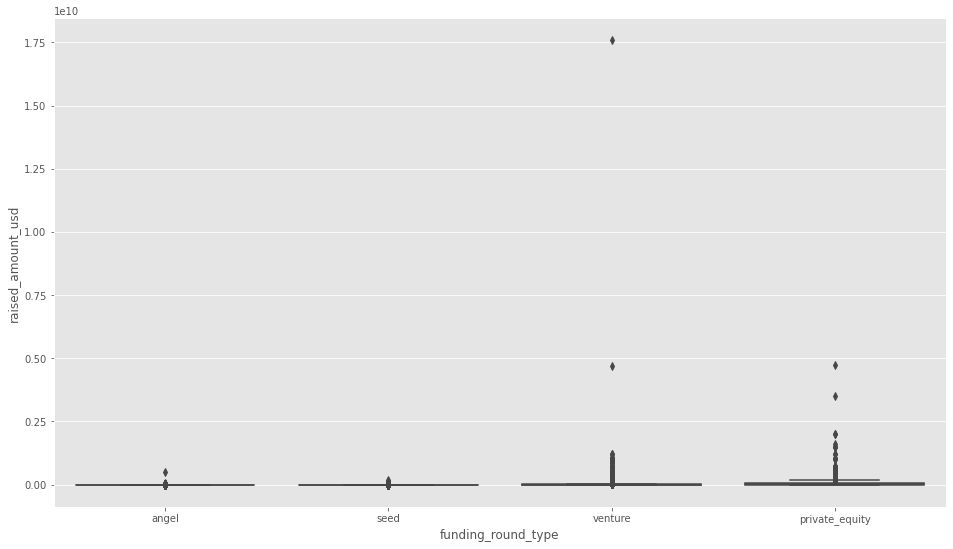

In [46]:
plt.figure(figsize=(16, 9))
sns.boxplot(data=master_frame, x='funding_round_type', y='raised_amount_usd', order=['angel', 'seed', 'venture', 'private_equity']);

As can be seen from the boxplot, the box are not visible and are squeezed because the ***dataset is heavily outliered. Hence, it is better to take median as a representative value*** than the mean.

In [47]:
# finding median of each type of investment
representative_inv_amt = funding_group[funding_group.index.isin(['angel', 'seed', 'venture', 'private_equity'])]['raised_amount_usd', '50%']
representative_inv_amt

funding_round_type
angel              410737.000
private_equity   20000000.000
seed               300000.000
venture           5000000.000
Name: (raised_amount_usd, 50%), dtype: float64

*We are given the funding budget is 5 Million to 15 Million USD. So let's check which type of investment lies in the budget*

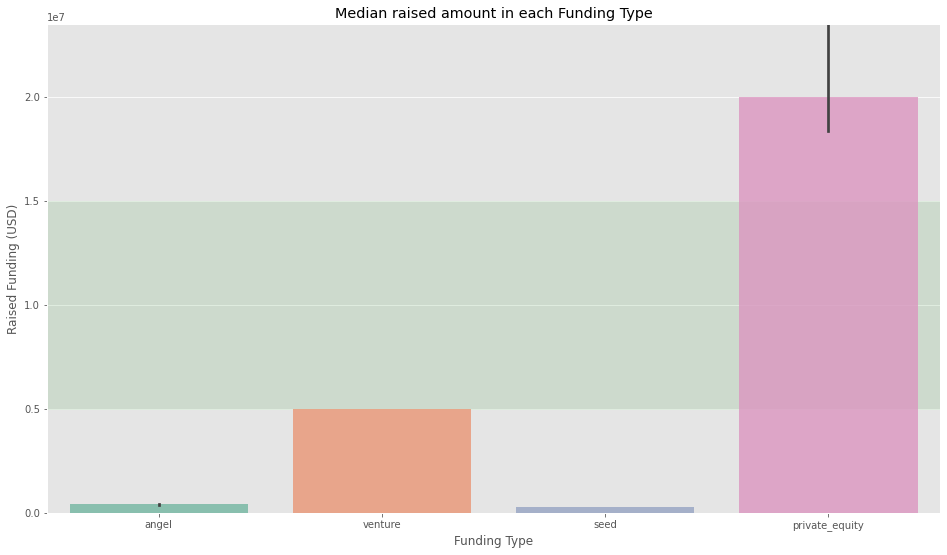

In [48]:
plt.figure(figsize=(16, 9));
# Plotting barplot for each of the Funding type (angel, venture, seed, private_equity) with their 'Most Representative Value i.e. Median'
axes=sns.barplot(data=master_frame,x='funding_round_type', y='raised_amount_usd', estimator=np.median, palette='Set2', order=['angel', 'venture', 'seed', 'private_equity'], alpha=0.8);

xlim=np.array(plt.gca().get_xlim())
# Marking the region of budget of investment given by Spark Funds: 5 Million - 15 Million
plt.fill_between(xlim, y1=2*[5000000], y2=2*[15000000], color="green", alpha=0.1)
# Removing margins for subplot
plt.margins(0)  
axes.set(xlabel='Funding Type', ylabel='Raised Funding (USD)', title='Median raised amount in each Funding Type');

In [49]:
# Finding the Funding Type whose raised amount lies between 5 Million and 15 Million
representative_inv_amt[(5000000 <= representative_inv_amt) & (representative_inv_amt <= 15000000)]

funding_round_type
venture   5000000.000
Name: (raised_amount_usd, 50%), dtype: float64

As can be seen in the graph  and data above, ***Venture funding lies in the investment budget*** provided by Spark Funds, it should be doing Venture Investment. <br /> Let's proceed by removing the other kinds of investments

In [50]:
# Filtering out investments other than 'Venture' investment
master_frame_venture = master_frame[master_frame.funding_round_type == 'venture']
master_frame_venture.head()

permalink                    name  \
0                   /organization/-fame                   #fame   
4                 /organization/0-6-com                 0-6.com   
8   /organization/0ndine-biomedical-inc  Ondine Biomedical Inc.   
10                 /organization/0xdata                  H2O.ai   
11                 /organization/0xdata                  H2O.ai   

    category_list     status country_code  \
0           Media  operating          IND   
4     Curated Web  operating          CHN   
8   Biotechnology  operating          CAN   
10      Analytics  operating          USA   
11      Analytics  operating          USA   

                            funding_round_permalink funding_round_type  \
0   /funding-round/9a01d05418af9f794eebff7ace91f638            venture   
4   /funding-round/5727accaeaa57461bd22a9bdd945382d            venture   
8   /funding-round/954b9499724b946ad8c396a57a5f3b72            venture   
10  /funding-round/3bb2ee4a2d89251a10aaa735b1180e44            venture   
11  /funding-round/ae2a174c06517c2394aed45006322a7e            venture   

     funded_at  raised_amount_usd  
0   05-01-2015       10000000.000  
4   19-03-2008        2000000.000  
8   21-12-2009         719491.000  
10  09-11-2015       20000000.000  
11  03-01-2013        1700000.000

We can focus on top 9 countries for furher analysis since it is reasonable to invest in such countries where investments done are on higher numbers

In [51]:
# Categorize the data by country and find total investment in each country
ordered_country_funding = master_frame_venture.groupby(by='country_code').sum()

# Take the Top 9 countries
top_countries = ordered_country_funding.sort_values(by='raised_amount_usd', ascending=False).iloc[:9, :].index
top_countries = list(top_countries)
top_countries

['USA', 'CHN', 'GBR', 'IND', 'CAN', 'FRA', 'ISR', 'DEU', 'JPN']

*The Top 3 English speaking countries are USA, GBR(Great Britain) and IND(India)*

In [52]:
# Filter Data for only top 9 countries
top9 = master_frame_venture[master_frame_venture.country_code.isin(top_countries)]
#Reset index
top9.reset_index(inplace=True, drop=True)
top9.head()

permalink                    name  category_list  \
0                  /organization/-fame                   #fame          Media   
1                /organization/0-6-com                 0-6.com    Curated Web   
2  /organization/0ndine-biomedical-inc  Ondine Biomedical Inc.  Biotechnology   
3                 /organization/0xdata                  H2O.ai      Analytics   
4                 /organization/0xdata                  H2O.ai      Analytics   

      status country_code                          funding_round_permalink  \
0  operating          IND  /funding-round/9a01d05418af9f794eebff7ace91f638   
1  operating          CHN  /funding-round/5727accaeaa57461bd22a9bdd945382d   
2  operating          CAN  /funding-round/954b9499724b946ad8c396a57a5f3b72   
3  operating          USA  /funding-round/3bb2ee4a2d89251a10aaa735b1180e44   
4  operating          USA  /funding-round/ae2a174c06517c2394aed45006322a7e   

  funding_round_type   funded_at  raised_amount_usd  
0            venture  05-01-2015       10000000.000  
1            venture  19-03-2008        2000000.000  
2            venture  21-12-2009         719491.000  
3            venture  09-11-2015       20000000.000  
4            venture  03-01-2013        1700000.000

In [53]:
top9.groupby(by='country_code').sum().sort_values(by='raised_amount_usd')

raised_amount_usd
country_code                   
ALB                       0.000
PER                       0.000
PAN                       0.000
PAK                       0.000
OMN                       0.000
...                         ...
CAN              9583332317.000
IND             14391858718.000
GBR             20245627416.000
CHN             39835418773.000
USA            422510842796.000

[134 rows x 1 columns]

In [54]:
# Reading Sectors mapping file
sector_map = pd.read_csv('./mapping.csv', skiprows=[1])
sector_map.head()

category_list  Automotive & Sports  Blanks  Cleantech / Semiconductors  \
0                3D                    0       0                           0   
1       3D Printing                    0       0                           0   
2     3D Technology                    0       0                           0   
3        Accounting                    0       0                           0   
4  Active Lifestyle                    0       0                           0   

   Entertainment  Health  Manufacturing  News, Search and Messaging  Others  \
0              0       0              1                           0       0   
1              0       0              1                           0       0   
2              0       0              1                           0       0   
3              0       0              0                           0       0   
4              0       1              0                           0       0   

   Social, Finance, Analytics, Advertising  
0                                        0  
1                                        0  
2                                        0  
3                                        1  
4                                        0

Let's analyse the sectors a little for data cleanliness, and types of columns

In [55]:
sector_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687 entries, 0 to 686
Data columns (total 10 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   category_list                            687 non-null    object
 1   Automotive & Sports                      687 non-null    int64 
 2   Blanks                                   687 non-null    int64 
 3   Cleantech / Semiconductors               687 non-null    int64 
 4   Entertainment                            687 non-null    int64 
 5   Health                                   687 non-null    int64 
 6   Manufacturing                            687 non-null    int64 
 7   News, Search and Messaging               687 non-null    int64 
 8   Others                                   687 non-null    int64 
 9   Social, Finance, Analytics, Advertising  687 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 53.8+ KB


*The data types are correct, and no value is missing. Lets see if each of sector has atleast one category associated with it*

In [56]:
sector_map.sum(numeric_only=True)

Automotive & Sports                         22
Blanks                                       0
Cleantech / Semiconductors                  53
Entertainment                               89
Health                                      63
Manufacturing                               40
News, Search and Messaging                  72
Others                                     195
Social, Finance, Analytics, Advertising    153
dtype: int64

**'Blanks' column has no value associated so we can remove it.**

In [57]:
# Drop 'Blanks' column
sector_map.drop('Blanks', axis=1, inplace=True)
# Check if all columns hold atleast one value
sector_map.sum(numeric_only=True)

Automotive & Sports                         22
Cleantech / Semiconductors                  53
Entertainment                               89
Health                                      63
Manufacturing                               40
News, Search and Messaging                  72
Others                                     195
Social, Finance, Analytics, Advertising    153
dtype: int64

Now everything seems fine. **Let's segragate the primary sector of each company into a separate variable *primary_sector***. As a business rule, the first string before the vertical bar will be considered the primary sector.

In [58]:
'''
Function to pick the word before '|' if '|' exists; else whole word
'''
def get_sector(x):
    if '|' in x:
        return x[:x.index('|')]
    return x

top9['primary_sector'] = top9['category_list'].apply(get_sector)

In [59]:
# Randomly getting a glimpse of data
top9.sample(5)

permalink                 name  \
2166              /organization/altruik              Altruik   
14240             /organization/finalta              Finalta   
27460             /organization/oncopep              OncoPep   
1455   /organization/aggregateknowledge  Aggregate Knowledge   
21034            /organization/knowlent             Knowlent   

                                           category_list     status  \
2166                Search|Search Marketing|SEO|Software   acquired   
14240  Enterprises|Finance|Finance Technology|Financi...  operating   
27460                                      Biotechnology  operating   
1455                                         Advertising   acquired   
21034                                           Software  operating   

      country_code                          funding_round_permalink  \
2166           USA  /funding-round/903eeedeadc7a675fe95dc0b9aaff4d7   
14240          USA  /funding-round/64d4073f81f1f47618b276dc6026bfeb   
27460          USA  /funding-round/7960cb1c13531ee28818906b083ed284   
1455           USA  /funding-round/9b61e0acde7dee5777b5ad1ec5d4eadf   
21034          USA  /funding-round/d1fd73acece9183cf209332009883d62   

      funding_round_type   funded_at  raised_amount_usd primary_sector  
2166             venture  01-11-2009        4700000.000         Search  
14240            venture  26-10-2011          50000.000    Enterprises  
27460            venture  26-04-2012        2500000.000  Biotechnology  
1455             venture  06-01-2010        9000000.000    Advertising  
21034            venture  08-05-2006        2350000.000       Software

In [60]:
top9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44383 entries, 0 to 44382
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   permalink                44383 non-null  object  
 1   name                     44383 non-null  object  
 2   category_list            44383 non-null  object  
 3   status                   44383 non-null  category
 4   country_code             44383 non-null  category
 5   funding_round_permalink  44383 non-null  object  
 6   funding_round_type       44383 non-null  category
 7   funded_at                44383 non-null  object  
 8   raised_amount_usd        44383 non-null  float64 
 9   primary_sector           44383 non-null  object  
dtypes: category(3), float64(1), object(6)
memory usage: 2.5+ MB


All columns are having correct data type except the primary_sector. Let's convert it to a 'category' since it's a nominal variable

In [61]:
# Convert primary_sector to categorical 
top9.primary_sector = top9.primary_sector.astype('category')
top9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44383 entries, 0 to 44382
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   permalink                44383 non-null  object  
 1   name                     44383 non-null  object  
 2   category_list            44383 non-null  object  
 3   status                   44383 non-null  category
 4   country_code             44383 non-null  category
 5   funding_round_permalink  44383 non-null  object  
 6   funding_round_type       44383 non-null  category
 7   funded_at                44383 non-null  object  
 8   raised_amount_usd        44383 non-null  float64 
 9   primary_sector           44383 non-null  category
dtypes: category(4), float64(1), object(5)
memory usage: 2.3+ MB


We can see the sector mapping is having all data as 0 or 1 indicating if a particular category maps to a particular sector or not. This is not readable. **For ease of use, let's melt and convert the dataframe sector_map in long form**

In [62]:
# Converting the sector map to long form
sector_map_2 = pd.melt(sector_map, id_vars='category_list', var_name='main_sector', value_name='Value')
# Filtering out the rows which have no 'Value'
sector_map_2 = sector_map_2[sector_map_2.Value != 0]
# Drop Extra column
sector_map_2.drop('Value', axis=1, inplace=True)
# Reset index without introducing indexes into columns
sector_map_2.reset_index(inplace=True, drop=True)
sector_map_2.head()

category_list          main_sector
0  Adventure Travel  Automotive & Sports
1         Aerospace  Automotive & Sports
2              Auto  Automotive & Sports
3   Automated Kiosk  Automotive & Sports
4        Automotive  Automotive & Sports

Now we need to merge the sector map with funding data top9. But first lets check if all primary_sector in top9 are present in sector_map_2 or not.

In [63]:
uniq_sect_in_data = top9[~top9.primary_sector.isin(sector_map_2.category_list)].primary_sector.unique()
uniq_sect_in_data

['Analytics', 'Unknown', 'Finance', 'Nanotechnology', 'Business Analytics', ..., 'Retirement', 'Professional Networking', 'Financial Exchanges', 'Promotional', 'Task Management']
Length: 56
Categories (56, object): ['Analytics', 'Unknown', 'Finance', 'Nanotechnology', ..., 'Professional Networking', 'Financial Exchanges', 'Promotional', 'Task Management']

So there are 56 primary sectors of top9 dataframe not present in sector_map_2. Lets now check reverse- if there is any value in sector_map_2 that is not in top9 primary_sector

In [64]:
unavailable_sectors = sector_map_2[~sector_map_2.category_list.str.lower().isin(top9.primary_sector.str.lower())]
unavailable_sectors

category_list                              main_sector
6            Boating Industry                      Automotive & Sports
21       Unmanned Air Systems                      Automotive & Sports
22      Air Pollution Control               Cleantech / Semiconductors
23                Aquaculture               Cleantech / Semiconductors
27   Biomass Power Generation               Cleantech / Semiconductors
..                        ...                                      ...
669        Social Bookmarking  Social, Finance, Analytics, Advertising
670           Social Business  Social, Finance, Analytics, Advertising
677    Social Media Ma0gement  Social, Finance, Analytics, Advertising
679    Social Media Platforms  Social, Finance, Analytics, Advertising
682         Social Recruiting  Social, Finance, Analytics, Advertising

[155 rows x 2 columns]

As evident, there are lots of values which are not in primary_sector of top9. Lets analyse them further by randomly picking the values.

In [65]:
# Choose random sample of 20 rows
unavailable_sectors.sample(n=20, random_state=4)

category_list                              main_sector
605          Direct Advertising  Social, Finance, Analytics, Advertising
476        Professio0l Services                                   Others
158             Video Streaming                            Entertainment
124                     Jewelry                            Entertainment
99               Digital Sig0ge                            Entertainment
375                       Fruit                                   Others
500                  Smart Grid                                   Others
62   0tural Language Processing               Cleantech / Semiconductors
224          Speech Recognition                                   Health
458              Perso0lization                                   Others
121    Independent Music Labels                            Entertainment
550           Big Data A0lytics  Social, Finance, Analytics, Advertising
66               Renewable Tech               Cleantech / Semiconductors
634        Innovation Ma0gement  Social, Finance, Analytics, Advertising
329      Professio0l Networking               News, Search and Messaging
208                Neuroscience                                   Health
98     Digital Rights Ma0gement                            Entertainment
44             Energy Ma0gement               Cleantech / Semiconductors
226                   Veteri0ry                                   Health
61                0notechnology               Cleantech / Semiconductors

We can see that the word 'Ma0gement' is actually 'Management'. So we need to replace '0' with 'na'/ replace complete word Management.

In [66]:
# Replace '0' with 'na' as per the pattern
unavailable_sectors.category_list = unavailable_sectors.category_list.str.replace('Ma0gement', 'Management')
unavailable_sectors.sample(n=20, random_state=3)

category_list                              main_sector
561     Career Management  Social, Finance, Analytics, Advertising
23            Aquaculture               Cleantech / Semiconductors
124               Jewelry                            Entertainment
640             Lotteries  Social, Finance, Analytics, Advertising
71       Waste Management               Cleantech / Semiconductors
278       Building Owners               News, Search and Messaging
448           Oil and Gas                                   Others
45         Energy Storage               Cleantech / Semiconductors
208          Neuroscience                                   Health
650           Moneymaking  Social, Finance, Analytics, Advertising
204  Medical Professio0ls                                   Health
319             0vigation               News, Search and Messaging
399                   ICT                                   Others
389           Home Owners                                   Others
174               Can0bis                                   Health
210               Organic                                   Health
137             Musicians                            Entertainment
495       Shared Services                                   Others
659   Predictive A0lytics  Social, Finance, Analytics, Advertising
520          Universities                                   Others

Now Management is coming fine. But there are other words as well which need treatment. There is 0vigation which should be Navigation as can be inferred from the main_sector 'Search and Messaging'. There is Medical Professio0als which should be Medical Professionals as per the main sector 'Health'. Same with A0lytics- Analytics. So we observe a pattern. Everywhere there is a need to replace '0' with 'na' to make it a correct word. So lets do that on the sector_map_2 itself.

In [67]:
# Replace '0' with 'na'
sector_map_2.category_list = sector_map_2.category_list.str.replace('0', 'na')
#Convert tp title case so that words like navigation will match to Navigation
sector_map_2.category_list = sector_map_2.category_list.str.title() 
# Choose random sample of 10 rows for cross check
sector_map_2.sample(n=10, random_state=3)

category_list                              main_sector
445            Office Space                                   Others
336                     Seo               News, Search and Messaging
657        Personal Finance  Social, Finance, Analytics, Advertising
204   Medical Professionals                                   Health
416       Language Learning                                   Others
482              Recreation                                   Others
327            Peer-To-Peer               News, Search and Messaging
517                 Trading                                   Others
105  Entertainment Industry                            Entertainment
177                 Cooking                                   Health

So we see the values have been corrected. Lets check the sectors in top9 with sector_map again.

In [68]:
# Checking the sectors in primary_sector but NOT in category list of sector mapping
uniq_sect_in_data = top9[~top9.primary_sector.str.lower().isin(sector_map_2.category_list.str.lower())]
uniq_sect_in_data.primary_sector.unique()

['Unknown', 'Natural Gas Uses', 'Enterprise 2.0', 'Adaptive Equipment', 'Racing', ..., 'Biotechnology and Semiconductor', 'Rapidly Expanding', 'Product Search', 'GreenTech', 'Retirement']
Length: 11
Categories (11, object): ['Unknown', 'Natural Gas Uses', 'Enterprise 2.0', 'Adaptive Equipment', ..., 'Rapidly Expanding', 'Product Search', 'GreenTech', 'Retirement']

So **there are 11 sectors, (contrast to 56 as before),** that are in top9 dataframe and not in sector map. Lets check the other way round.

In [69]:
# Checking the sectors in category list of sectory mapping but NOT in primary sector in dataset
sector_map_2[~sector_map_2.category_list.str.lower().isin(top9.primary_sector.str.lower())]

category_list                              main_sector
6            Boating Industry                      Automotive & Sports
21       Unmanned Air Systems                      Automotive & Sports
22      Air Pollution Control               Cleantech / Semiconductors
23                Aquaculture               Cleantech / Semiconductors
27   Biomass Power Generation               Cleantech / Semiconductors
..                        ...                                      ...
669        Social Bookmarking  Social, Finance, Analytics, Advertising
670           Social Business  Social, Finance, Analytics, Advertising
677   Social Media Management  Social, Finance, Analytics, Advertising
679    Social Media Platforms  Social, Finance, Analytics, Advertising
682         Social Recruiting  Social, Finance, Analytics, Advertising

[110 rows x 2 columns]

So **there are 110 sectors** that do not have any company in the given data. This is **down by 46 after treament of the misspelled words in sector_map.**

In [70]:
top9 = top9.astype({'status':'category', 'country_code':'category', 'funding_round_type':'category', 'primary_sector':'category'})
# Resetting the categorical variables to include only those categories whose values are present in column
top9.status = top9.status.cat.remove_unused_categories()
top9.funding_round_type = top9.funding_round_type.cat.remove_unused_categories()
top9.primary_sector = top9.primary_sector.cat.remove_unused_categories()
top9.country_code = top9.country_code.cat.remove_unused_categories()

top9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44383 entries, 0 to 44382
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   permalink                44383 non-null  object  
 1   name                     44383 non-null  object  
 2   category_list            44383 non-null  object  
 3   status                   44383 non-null  category
 4   country_code             44383 non-null  category
 5   funding_round_permalink  44383 non-null  object  
 6   funding_round_type       44383 non-null  category
 7   funded_at                44383 non-null  object  
 8   raised_amount_usd        44383 non-null  float64 
 9   primary_sector           44383 non-null  category
dtypes: category(4), float64(1), object(5)
memory usage: 2.3+ MB


*Now that the data in both sector mapping and funding dataset is in coherence, we can go ahead and merge the two.*

In [71]:
# Merge sector map with the dataset in order to map each company to one of the 8 main sectors
top9 = pd.merge(top9, sector_map_2, left_on='primary_sector', right_on='category_list', how='inner')
# Drop redundant column
top9.drop('category_list_y', axis=1, inplace=True)
# Rename column post merge
top9.rename(columns={'category_list_x': 'category_list'},inplace=True)
top9.head()

permalink             name  \
0            /organization/-fame            #fame   
1            /organization/90min            90min   
2            /organization/90min            90min   
3            /organization/90min            90min   
4  /organization/all-def-digital  All Def Digital   

                         category_list     status country_code  \
0                                Media  operating          IND   
1  Media|News|Publishing|Soccer|Sports  operating          GBR   
2  Media|News|Publishing|Soccer|Sports  operating          GBR   
3  Media|News|Publishing|Soccer|Sports  operating          GBR   
4                                Media  operating          USA   

                           funding_round_permalink funding_round_type  \
0  /funding-round/9a01d05418af9f794eebff7ace91f638            venture   
1  /funding-round/21a2cbf6f2fb2a1c2a61e04bf930dfe6            venture   
2  /funding-round/bd626ed022f5c66574b1afe234f3c90d            venture   
3  /funding-round/fd4b15e8c97ee2ffc0acccdbe1a98810            venture   
4  /funding-round/452a2342fe720285c3b92e9bd927d9ba            venture   

    funded_at  raised_amount_usd primary_sector    main_sector  
0  05-01-2015       10000000.000          Media  Entertainment  
1  06-10-2015       15000000.000          Media  Entertainment  
2  07-05-2013        5800000.000          Media  Entertainment  
3  26-03-2014       18000000.000          Media  Entertainment  
4  06-08-2014        5000000.000          Media  Entertainment

In [72]:
# Converting main_Sector, primary_sector to categorical variable
top9.primary_sector = top9.primary_sector.astype('category')
top9.main_sector = top9.main_sector.astype('category')
top9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42444 entries, 0 to 42443
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   permalink                42444 non-null  object  
 1   name                     42444 non-null  object  
 2   category_list            42444 non-null  object  
 3   status                   42444 non-null  category
 4   country_code             42444 non-null  category
 5   funding_round_permalink  42444 non-null  object  
 6   funding_round_type       42444 non-null  category
 7   funded_at                42444 non-null  object  
 8   raised_amount_usd        42444 non-null  float64 
 9   primary_sector           42444 non-null  category
 10  main_sector              42444 non-null  category
dtypes: category(5), float64(1), object(5)
memory usage: 2.5+ MB


Now that we are done merging sector mapping with the funding data, we can proceed with out next analysis: ** Country Level Analysis** <br/>
For that, let's check the top countries with total raised amount

Now the Top English Speaking countries are *USA, GBR* and *IND.* Let's analyse each country separately.

In [73]:
# Filtering out each of the top 3 english speaking country into its own dataframe, where funding is 'venture' and raised_amount lies between 5 Million to 15 Million
D1 = top9[(top9.country_code == 'USA') & (top9.funding_round_type == 'venture') & (top9.raised_amount_usd <=15000000) & (top9.raised_amount_usd >= 5000000)]
D2 = top9[(top9.country_code == 'GBR') & (top9.funding_round_type == 'venture') & (top9.raised_amount_usd <=15000000) & (top9.raised_amount_usd >= 5000000)]
D3 = top9[(top9.country_code == 'IND') & (top9.funding_round_type == 'venture') & (top9.raised_amount_usd <=15000000) & (top9.raised_amount_usd >= 5000000)]


In [74]:
'''
A function to find the most invested company in given sector and country
'''
def find_top_company(data, country, sector):
    max_d3 = data[data.main_sector == sector].groupby(by='permalink').sum().sort_values(by='raised_amount_usd', ascending=False)
    return 'Top investment receiving company in {0} in {1} sector is: {2}'.format(country, sector, data[max_d3.index[0] == data.permalink].name.iloc[0])

### USA Analysis

In [75]:
# Analysing USA (America)
df=D1.groupby(by='main_sector').agg({'raised_amount_usd':['count', 'sum']}).raised_amount_usd
print('Total investments in USA: '+str(D1.shape[0]))
print('Total investment amount in USA: ' + str(D1.raised_amount_usd.sum()))
df.sort_values(by='count', ascending=False)

Total investments in USA: 11674
Total investment amount in USA: 104352443172.0


count             sum
main_sector                                                   
Others                                    2846 25391336329.000
Social, Finance, Analytics, Advertising   2647 23228761428.000
Cleantech / Semiconductors                2349 21626721421.000
News, Search and Messaging                1579 13925067428.000
Manufacturing                              797  7243253378.000
Health                                     706  6449400845.000
Entertainment                              585  5050947982.000
Automotive & Sports                        165  1436954361.000

In [76]:
# Finding out company with highest investment in 'Others' sector
print(find_top_company(D1, 'USA', 'Others'))
# Finding out company with highest investment in Social, Finance, Analytics, Advertising sector
print(find_top_company(D1, 'USA', 'Social, Finance, Analytics, Advertising'))
# Finding out company with highest investment in Cleantech / Semiconductors sector
print(find_top_company(D1, 'USA', 'Cleantech / Semiconductors'))

Top investment receiving company in USA in Others sector is: Virtustream
Top investment receiving company in USA in Social, Finance, Analytics, Advertising sector is: SST Inc. (Formerly ShotSpotter)
Top investment receiving company in USA in Cleantech / Semiconductors sector is: Biodesix


### Great Britain Analysis

In [77]:
# Analysing GBR (Great Britain)
df=D2.groupby(by='main_sector').agg({'raised_amount_usd':['count', 'sum']}).raised_amount_usd
print('Total investments in Great Britain: '+str(D2.shape[0]))
print('Total investment amount in Great Britain: ' + str(D2.raised_amount_usd.sum()))
df.sort_values(by='count', ascending=False)

Total investments in Great Britain: 610
Total investment amount in Great Britain: 5293052543.0


count            sum
main_sector                                                  
Others                                     145 1269064758.000
Cleantech / Semiconductors                 130 1163990056.000
Social, Finance, Analytics, Advertising    128 1045083891.000
News, Search and Messaging                  73  615746235.000
Entertainment                               56  482784687.000
Manufacturing                               42  361940335.000
Health                                      20  187391016.000
Automotive & Sports                         16  167051565.000

In [78]:
# Finding out company with highest investment in 'Others' sector
print(find_top_company(D2, 'Great Britain', 'Others'))
# Finding out company with highest investment in Cleantech / Semiconductors sector
print(find_top_company(D2, 'Great Britain', 'Cleantech / Semiconductors'))
# Finding out company with highest investment in Social, Finance, Analytics, Advertising sector
print(find_top_company(D2, 'Great Britain', 'Social, Finance, Analytics, Advertising'))

Top investment receiving company in Great Britain in Others sector is: Electric Cloud
Top investment receiving company in Great Britain in Cleantech / Semiconductors sector is: EUSA Pharma
Top investment receiving company in Great Britain in Social, Finance, Analytics, Advertising sector is: Celltick Technologies


### India Analysis

In [79]:
# Analysing IND (India)
df=D3.groupby(by='main_sector').agg({'raised_amount_usd':['count', 'sum']}).raised_amount_usd
print('Total investments in India: '+str(D3.shape[0]))
print('Total investment amount in India: ' + str(D3.raised_amount_usd.sum()))
df.sort_values(by='count', ascending=False)

Total investments in India: 313
Total investment amount in India: 2802560102.0


count           sum
main_sector                                                 
Others                                     105 962069507.000
Social, Finance, Analytics, Advertising     58 534546050.000
News, Search and Messaging                  52 433834545.000
Entertainment                               33 280830000.000
Manufacturing                               21 200900000.000
Cleantech / Semiconductors                  20 165380000.000
Automotive & Sports                         13 136900000.000
Health                                      11  88100000.000

In [80]:
# Finding out company with highest investment in 'Others' sector
print(find_top_company(D3, 'India', 'Others'))
# Finding out company with highest investment in Social, Finance, Analytics, Advertising sector
print(find_top_company(D3, 'India', 'Social, Finance, Analytics, Advertising'))
# Finding out company with highest investment in News, Search and Messaging sector
print(find_top_company(D3, 'India', 'News, Search and Messaging'))

Top investment receiving company in India in Others sector is: FirstCry.com
Top investment receiving company in India in Social, Finance, Analytics, Advertising sector is: Manthan Systems
Top investment receiving company in India in News, Search and Messaging sector is: GupShup


# Summary

### 1. The Funding Type within the range of 5 Million to 15 Million is Venture. This is the type Spark Funds should invest in.
### 2. Top 3 English Speaking countries, that raise funding for each company within the investment budget of Spark Funds are USA, Great Britain and India
### 3. Top 3 Sectors in each of these countries for investments come out to be:
**
USA : <br/>
 1. Others<br/>
 2. Social, Finance, Analytics, Advertising <br/>
 3. Cleantech / Semiconductors <br/>
**

**
Great Britain: <br/>
1. Others <br/>
2. Cleantech / Semiconductors <br/>
3. Social, Finance, Analytics, Advertising <br/> **

** India: <br/>
    1. Others <br/>
    2. Social, Finance, Analytics, Advertising,  <br/>
    3. News, Search and Messaging <br/>
**

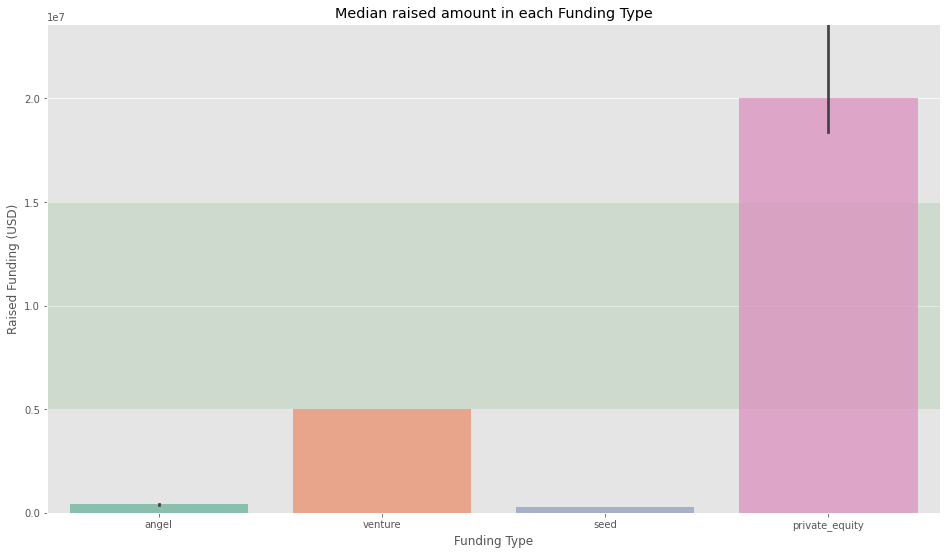

In [81]:
plt.figure(figsize=(16, 9));
# Plotting barplot for each of the Funding type (angel, venture, seed, private_equity) with their 'Most Representative Value i.e. Median'
axes=sns.barplot(data=master_frame,x='funding_round_type', y='raised_amount_usd', estimator=np.median, palette='Set2', order=['angel', 'venture', 'seed', 'private_equity'], alpha=0.8);

xlim=np.array(plt.gca().get_xlim())
# Marking the region of budget of investment given by Spark Funds- 5Million-15Million
plt.fill_between(xlim, y1=2*[5000000], y2=2*[15000000], color="green", alpha=0.1)
# Removing margins for subplot
plt.margins(0)  
axes.set(xlabel='Funding Type', ylabel='Raised Funding (USD)', title='Median raised amount in each Funding Type');

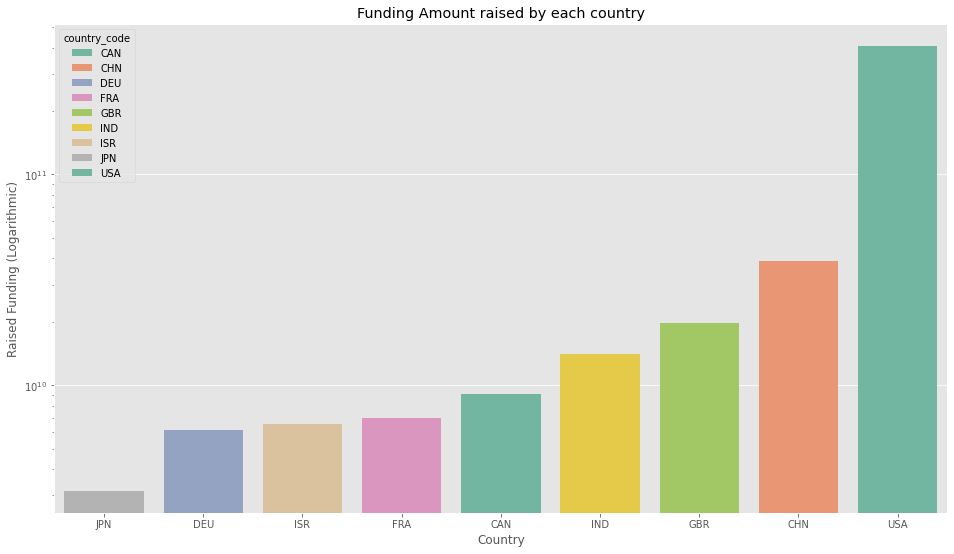

In [82]:
plt.figure(figsize=(16, 9));
# Store the order of countries as per total raised amount
figorder = top9.groupby(by='country_code').sum().sort_values(by='raised_amount_usd').index

axes = sns.barplot(data=top9, x='country_code', y='raised_amount_usd', palette='Set2', estimator=np.sum, ci=None, hue='country_code', order=figorder, dodge=False);
# Setting axes labels and plot title, changing scale to Log base 10
axes.set(xlabel='Country', ylabel='Raised Funding (Logarithmic)', title='Funding Amount raised by each country', yscale='log');

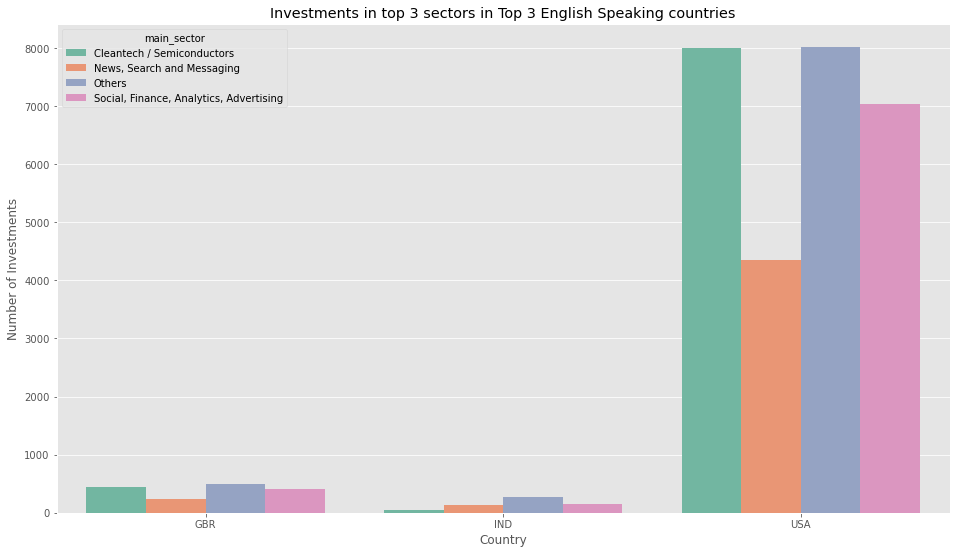

In [83]:
# Filtering the Top 3 Countries, with Top 3 Sectors
top3 = top9[(top9.country_code.isin(['USA','GBR','IND'])) & (top9.main_sector.isin(['Social, Finance, Analytics, Advertising', 'Others', 'Cleantech / Semiconductors', 'News, Search and Messaging']))]
# Resetting the categorical variables to include only those categories whose values are present in column
top3.country_code = top3.country_code.cat.remove_unused_categories()
top3.main_sector = top3.main_sector.cat.remove_unused_categories()
plt.figure(figsize=(16,9));
# Plot graph to show the number of investments in the top 3 sectors of the top 3 countries for Investment 'venture'
axes = sns.barplot(data=top3, x='country_code', y='raised_amount_usd', estimator=len, hue='main_sector', palette='Set2', ci=None);
axes.set(title='Investments in top 3 sectors in Top 3 English Speaking countries', xlabel='Country', ylabel='Number of Investments');